# MaterialsZone - The Lean R&D Solution
## Technical Exercise for Lead AI Engineer Position

### Ofir Suranyi

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from sklearn.preprocessing import LabelEncoder,StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet,BayesianRidge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from typing import Dict, Union, Any, Callable

sns.set()

### Load both datasets

In [2]:
raw_materials_path = 'datasets/raw_materials.csv'
formulations_path = 'datasets/formulations.csv'

raw_materials_df = pd.read_csv(raw_materials_path)
formulations_df = pd.read_csv(formulations_path)
formulations_df_final = formulations_df.copy()

## Data exploration

In [3]:
# Check for missing values and data types in both datasets
missing_values_raw = raw_materials_df.isnull().sum().sum()
data_types_raw = raw_materials_df.dtypes
print(f'\nMissing values in raw_materials : {missing_values_raw}\n')

print(data_types_raw)
missing_values_formulations = formulations_df.isnull().sum().sum()
data_types_formulations = formulations_df.dtypes

print(f'\nMissing values in formulations : {missing_values_formulations}\n')
print(data_types_formulations)



Missing values in raw_materials : 0

Raw_Material_ID       object
Raw_Material_Name     object
Melting_Point        float64
Density              float64
Purity               float64
dtype: object

Missing values in formulations : 5

Formulation_ID             object
Formulation_Name           object
Processing_Temperature    float64
Processing_Time           float64
Processing_Pressure       float64
RM1                       float64
RM2                       float64
RM3                       float64
RM4                       float64
RM5                       float64
RM6                       float64
RM7                       float64
RM8                       float64
RM9                       float64
RM10                      float64
RM11                      float64
RM12                      float64
RM13                      float64
RM14                      float64
RM15                      float64
RM16                      float64
RM17                      float64
RM18              

In [4]:
formulations_df = formulations_df.set_index(formulations_df.Formulation_ID)
RM_df = formulations_df[['RM'+str(i)for i in range(1,31)]]
experiment_df = formulations_df[['Processing_Temperature',
       'Processing_Time', 'Processing_Pressure']]
Target = formulations_df[["Tensile_Strength"]]
raw_materials_df[["Raw_Material","Sensor"]] = raw_materials_df.Raw_Material_Name.str.split('-', expand=True)
raw_materials_df = raw_materials_df.drop("Raw_Material_Name",axis = 1)

## Visualization

In [5]:
class Visualization:

    def __init__(self,df: pd.DataFrame):
        self.df = df
    
    # Function to calculate robust sigma
    def calculate_robust_sigma(self,data):
        scaling_factor = 1.4826
        return scaling_factor * np.median(np.abs(data - np.median(data)))

    def plot_histograms(self,rows,cols, bins: int = 30) -> None:
        np.random.seed(10)  # For reproducibility

        fig, axs = plt.subplots(rows, cols, figsize=(int(12*(cols/3)), int(15*(rows/6))), gridspec_kw={"height_ratios": (.15, .85)*int(rows/2) })

        # Iterate over the features to plot boxplot and histogram for each
        for i, feature in enumerate(self.df.columns):
            row = (i // 3) * 2  # Determine row for boxplot
            col = i % 3         # Determine column
            
            # Boxplot
            sns.boxplot(data=self.df, x=feature, ax=axs[row, col], orient="h", palette="Set2")
            axs[row, col].set(xlabel='', title=f'Boxplot of {feature}')
            
            # Histogram
            sns.histplot(data=self.df[feature], ax=axs[row+1, col], bins=bins, kde=True, edgecolor=".3", linewidth=.5)
            axs[row+1, col].set(title=f'Histogram of {feature}')
            robust_sigma = self.calculate_robust_sigma(self.df[feature])
            median = np.median(self.df[feature])
            axs[row+1, col].axvline(median, color='red', linestyle='--', label='Median')
            axs[row+1, col].axvline(median + robust_sigma, color='green', linestyle='-', label='Robust Sigma')
            axs[row+1, col].axvline(median - robust_sigma, color='green', linestyle='-', label=None)
            axs[row+1, col].legend()
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
        plt.show()

    def pairplot_histograms(self, plot_features: list[str],hue_column: str = None) -> None:
        
        sns.pairplot(self.df[plot_features], corner=True, hue = hue_column)
        plt.show()

    def plot_correlation_matrix(self) -> None:
        cor = self.df.corr().round(2)
        mask = np.zeros_like(cor)
        mask[np.triu_indices_from(mask)] = True
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
        plt.figure()
        sns.heatmap(cor, mask=mask, annot=True, annot_kws={"size": 10},
                    center=0, cmap=cmap, square=False, linewidths=.5,
                    cbar_kws={"shrink": .5}, yticklabels=1, xticklabels=1, vmin=-1, vmax=1)
        plt.title("correlation matrix", fontsize='xx-large', fontweight='bold')

        plt.show()

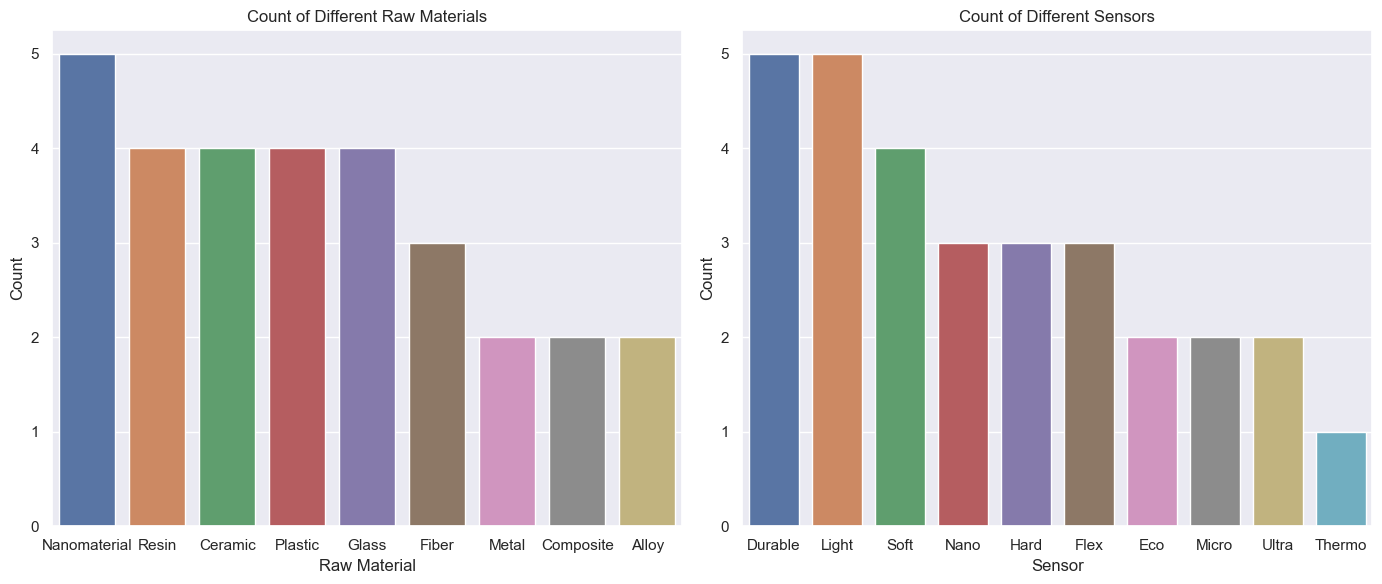

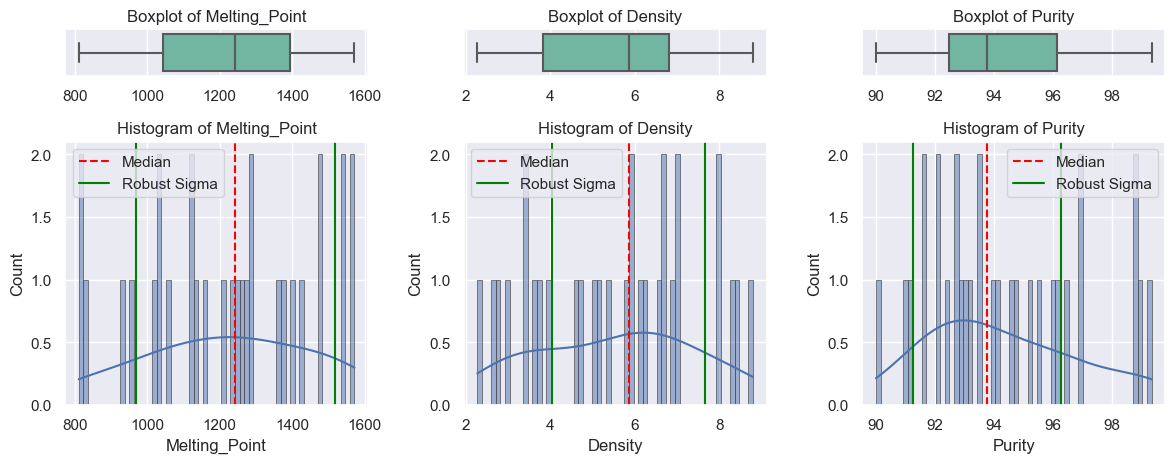

In [6]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plotting countplot for Raw_Material sorted by frequency
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
raw_material_order = raw_materials_df['Raw_Material'].value_counts().index
sns.countplot(x='Raw_Material', data=raw_materials_df, order=raw_material_order)
plt.title('Count of Different Raw Materials')
plt.xlabel('Raw Material')
plt.ylabel('Count')

# Plotting countplot for Sensor sorted by frequency
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sensor_order = raw_materials_df['Sensor'].value_counts().index
sns.countplot(x='Sensor', data=raw_materials_df, order=sensor_order)
plt.title('Count of Different Sensors')
plt.xlabel('Sensor')
plt.ylabel('Count')

# Show the plot
plt.tight_layout()
plt.show()

vis_raw_materials_df = Visualization(df = raw_materials_df.select_dtypes(include=[np.number]))
vis_raw_materials_df.plot_histograms(bins = 60,rows= 2,cols = 3)

### Heatmap showing RM's percentages in each formulation 

In [27]:
Target.column

,Tensile_Strength
Formulation_ID,
F1,498.05
F2,517.93
F3,425.43
F4,505.06
F5,515.62
F6,416.85
F7,506.26
F8,395.90
F9,459.15


In [30]:
RM_df_tar = RM_df.copy()
RM_df_tar["Tensile_Strength"] = Target

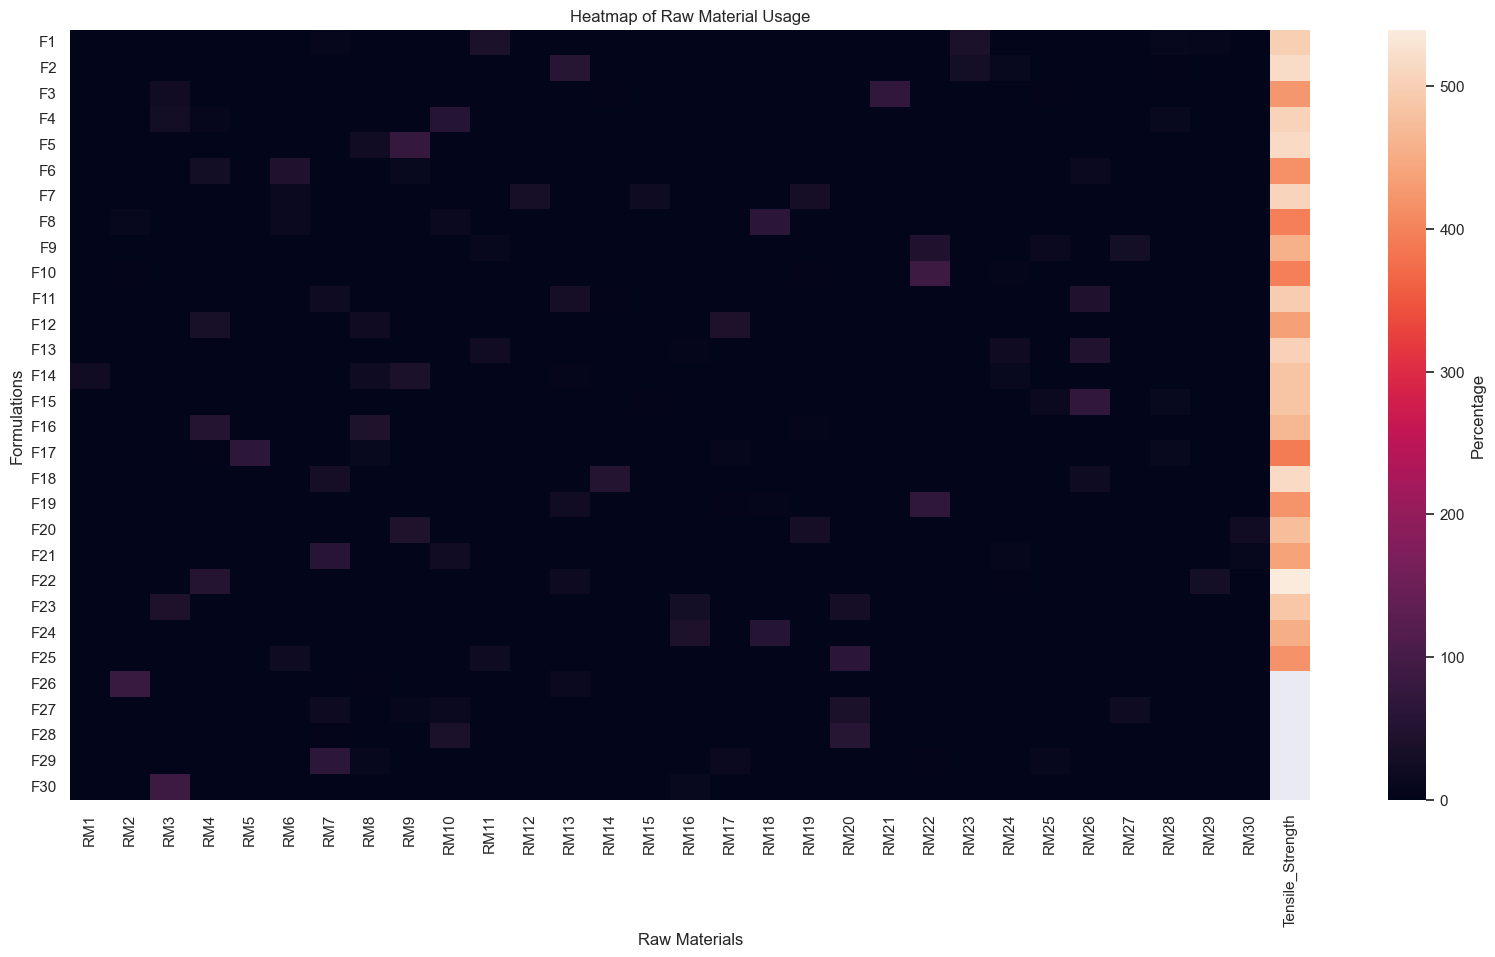

In [32]:
plt.figure(figsize=(20, 10))
sns.heatmap(RM_df_tar,  cbar_kws={'label': 'Percentage'})
plt.title('Heatmap of Raw Material Usage')
plt.xlabel('Raw Materials')
plt.ylabel('Formulations')
plt.show()

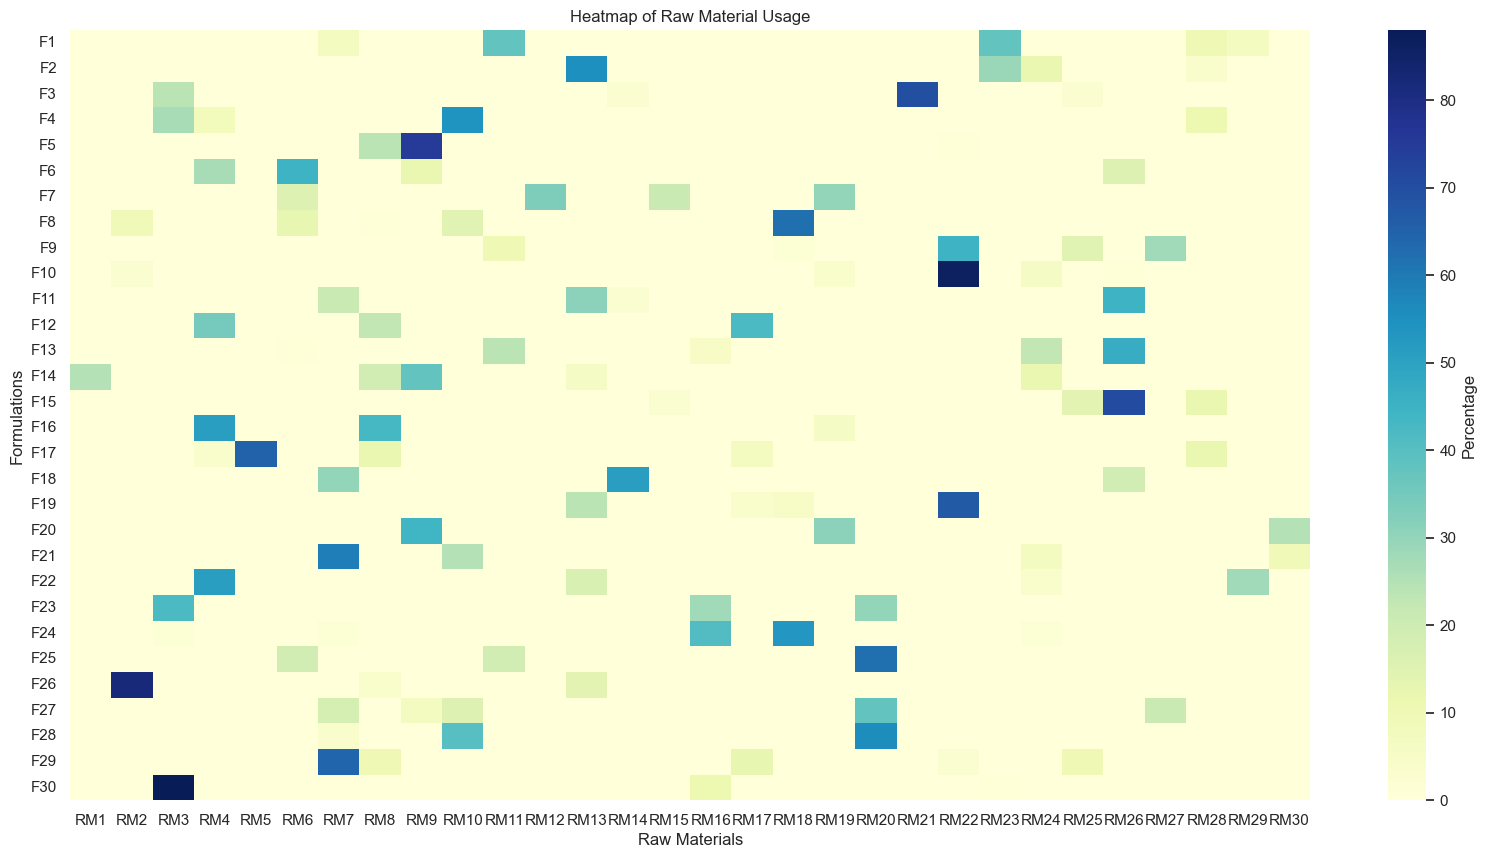

In [7]:
plt.figure(figsize=(20, 10))
sns.heatmap(RM_df, cmap="YlGnBu", cbar_kws={'label': 'Percentage'})
plt.title('Heatmap of Raw Material Usage')
plt.xlabel('Raw Materials')
plt.ylabel('Formulations')
plt.show()

## Preprocessing


In [8]:
# Dictionary to hold the non-zero RM values for each row
non_zero_rm_dict = {}

# Iterate over each row in RM_df
for index, row in RM_df.iterrows():
    # Filter out columns where the value is not zero
    non_zero_values = row[row != 0]
    # Store in dictionary: key is the row index, and value is another dictionary of RM names and their values
    non_zero_rm_dict[index] = dict(non_zero_values)

def formulations_dict_to_dataframe(formulations_dict):
    # Create a list to hold the data
    data = []
    
    # Iterate over each formulation in the dictionary
    for formulation_id, materials in formulations_dict.items():
        # Iterate over each material in the formulation
        for raw_material_id, percentage in materials.items():
            # Append each item as a row in the data list
            data.append({
                'Formulation_ID': formulation_id,
                'Raw_Material_ID': raw_material_id,
                'Percentage': percentage
            })
    
    # Convert the list of data into a DataFrame
    return pd.DataFrame(data)

agg_RM_df = formulations_dict_to_dataframe(non_zero_rm_dict)

agg_RM_df

,Formulation_ID,Raw_Material_ID,Percentage
0,F1,RM7,7.0
1,F1,RM11,38.0
2,F1,RM23,38.0
3,F1,RM28,10.0
4,F1,RM29,7.0
...,...,...,...
115,F29,RM22,3.0
116,F29,RM25,10.0
117,F30,RM3,88.0
118,F30,RM16,11.0


The melting point of a pure substance is always higher 

and has a smaller range than the melting point of an impure substance or, more generally, of mixtures.

In [9]:
formulations_with_properties = agg_RM_df.merge(raw_materials_df, on='Raw_Material_ID', how='left')
formulations_with_properties

,Formulation_ID,Raw_Material_ID,Percentage,Melting_Point,Density,Purity,Raw_Material,Sensor
0,F1,RM7,7.0,1381.8,6.68,91.04,Resin,Soft
1,F1,RM11,38.0,1568.9,5.93,98.74,Alloy,Flex
2,F1,RM23,38.0,1115.9,8.27,94.80,Plastic,Light
3,F1,RM28,10.0,1432.1,6.23,92.17,Resin,Durable
4,F1,RM29,7.0,1284.8,5.78,95.53,Ceramic,Ultra
...,...,...,...,...,...,...,...,...
115,F29,RM22,3.0,1138.7,3.41,95.29,Plastic,Thermo
116,F29,RM25,10.0,811.3,5.94,92.67,Nanomaterial,Nano
117,F30,RM3,88.0,1473.8,7.95,96.88,Nanomaterial,Eco
118,F30,RM16,11.0,1572.2,3.65,92.69,Glass,Soft


### Feature Engineering

In [10]:
formulations_with_properties["Partial_Density"] = 0.01*formulations_with_properties["Percentage"]*formulations_with_properties["Density"]
formulations_with_properties["Partial_Melting_Point"] = 0.01*formulations_with_properties["Percentage"]*formulations_with_properties["Melting_Point"]
formulations_with_properties["Partial_Purity"] = 0.01*formulations_with_properties["Percentage"]*formulations_with_properties["Purity"]

formulations_with_properties = formulations_with_properties.drop(["Melting_Point","Purity","Density","Percentage"],axis = 1)

formulations_with_properties

,Formulation_ID,Raw_Material_ID,Raw_Material,Sensor,Partial_Density,Partial_Melting_Point,Partial_Purity
0,F1,RM7,Resin,Soft,0.4676,96.726,6.3728
1,F1,RM11,Alloy,Flex,2.2534,596.182,37.5212
2,F1,RM23,Plastic,Light,3.1426,424.042,36.0240
3,F1,RM28,Resin,Durable,0.6230,143.210,9.2170
4,F1,RM29,Ceramic,Ultra,0.4046,89.936,6.6871
...,...,...,...,...,...,...,...
115,F29,RM22,Plastic,Thermo,0.1023,34.161,2.8587
116,F29,RM25,Nanomaterial,Nano,0.5940,81.130,9.2670
117,F30,RM3,Nanomaterial,Eco,6.9960,1296.944,85.2544
118,F30,RM16,Glass,Soft,0.4015,172.942,10.1959


### Label encode each of the categorical columns

In [11]:
# Initialize LabelEncoder
le = LabelEncoder()

formulations_with_properties['Formulation_ID_encoded'] = le.fit_transform(formulations_with_properties['Formulation_ID'])
formulations_with_properties['Raw_Material_ID_encoded'] = le.fit_transform(formulations_with_properties['Raw_Material_ID'])
#formulations_with_properties['Raw_Material_encoded'] = le.fit_transform(formulations_with_properties['Raw_Material']) #Apply only when data is real
#formulations_with_properties['Sensor_encoded'] = le.fit_transform(formulations_with_properties['Sensor']) #Apply only when data is real

# Drop original categorical columns if no longer needed
formulations_with_properties.drop(["Formulation_ID",'Raw_Material_ID', 'Raw_Material', 'Sensor'], axis=1, inplace=True)
formulations_with_properties

,Partial_Density,Partial_Melting_Point,Partial_Purity,Formulation_ID_encoded,Raw_Material_ID_encoded
0,0.4676,96.726,6.3728,0,27
1,2.2534,596.182,37.5212,0,2
2,3.1426,424.042,36.0240,0,15
3,0.6230,143.210,9.2170,0,20
4,0.4046,89.936,6.6871,0,21
...,...,...,...,...,...
115,0.1023,34.161,2.8587,21,14
116,0.5940,81.130,9.2670,21,17
117,6.9960,1296.944,85.2544,23,22
118,0.4015,172.942,10.1959,23,7


### Calculate cosine distances

In [12]:
def calculate_average_distance(group):
    
    distances = pdist(group, metric='cosine')
    # Calculate the average of these distances
    average_distance = distances.sum()
    return average_distance
cols = 3
# Group by Formulation_ID and apply the average distance calculation
experiment_df = experiment_df.reset_index(drop = False)
experiment_df["sum_distances"] = formulations_with_properties.groupby('Formulation_ID_encoded').apply(calculate_average_distance)
experiment_df["Number_of_Materials"] = formulations_df["Number_of_Materials"].values
experiment_df[["wheighted_"+i[8:] for i in formulations_with_properties.columns[:cols]]] = formulations_with_properties.groupby('Formulation_ID_encoded').sum()[formulations_with_properties.columns[:cols]].values
experiment_df = experiment_df.set_index("Formulation_ID")
experiment_df

,Processing_Temperature,Processing_Time,Processing_Pressure,sum_distances,Number_of_Materials,wheighted_Density,wheighted_Melting_Point,wheighted_Purity
Formulation_ID,,,,,,,,
F1,213.0,4.43,4.64,0.137207,5,6.8912,1350.096,95.8221
F2,250.8,2.30,8.99,1.551091,4,3.8519,1117.194,95.3027
F3,249.4,1.88,8.66,0.022937,4,7.4605,1192.076,91.7884
F4,339.3,3.84,9.42,0.007573,4,4.9261,1189.958,96.7838
F5,342.5,4.24,8.07,1.810380,3,6.1065,1159.340,94.9766
F6,229.6,2.39,7.02,0.038286,4,6.4062,1200.660,94.9079
F7,399.5,1.38,6.23,0.047928,4,6.6684,1004.477,92.6218
F8,253.4,4.76,4.35,0.021271,5,5.9085,1110.034,96.6002
F9,395.3,2.59,9.46,0.327725,5,3.7536,1161.045,95.6173


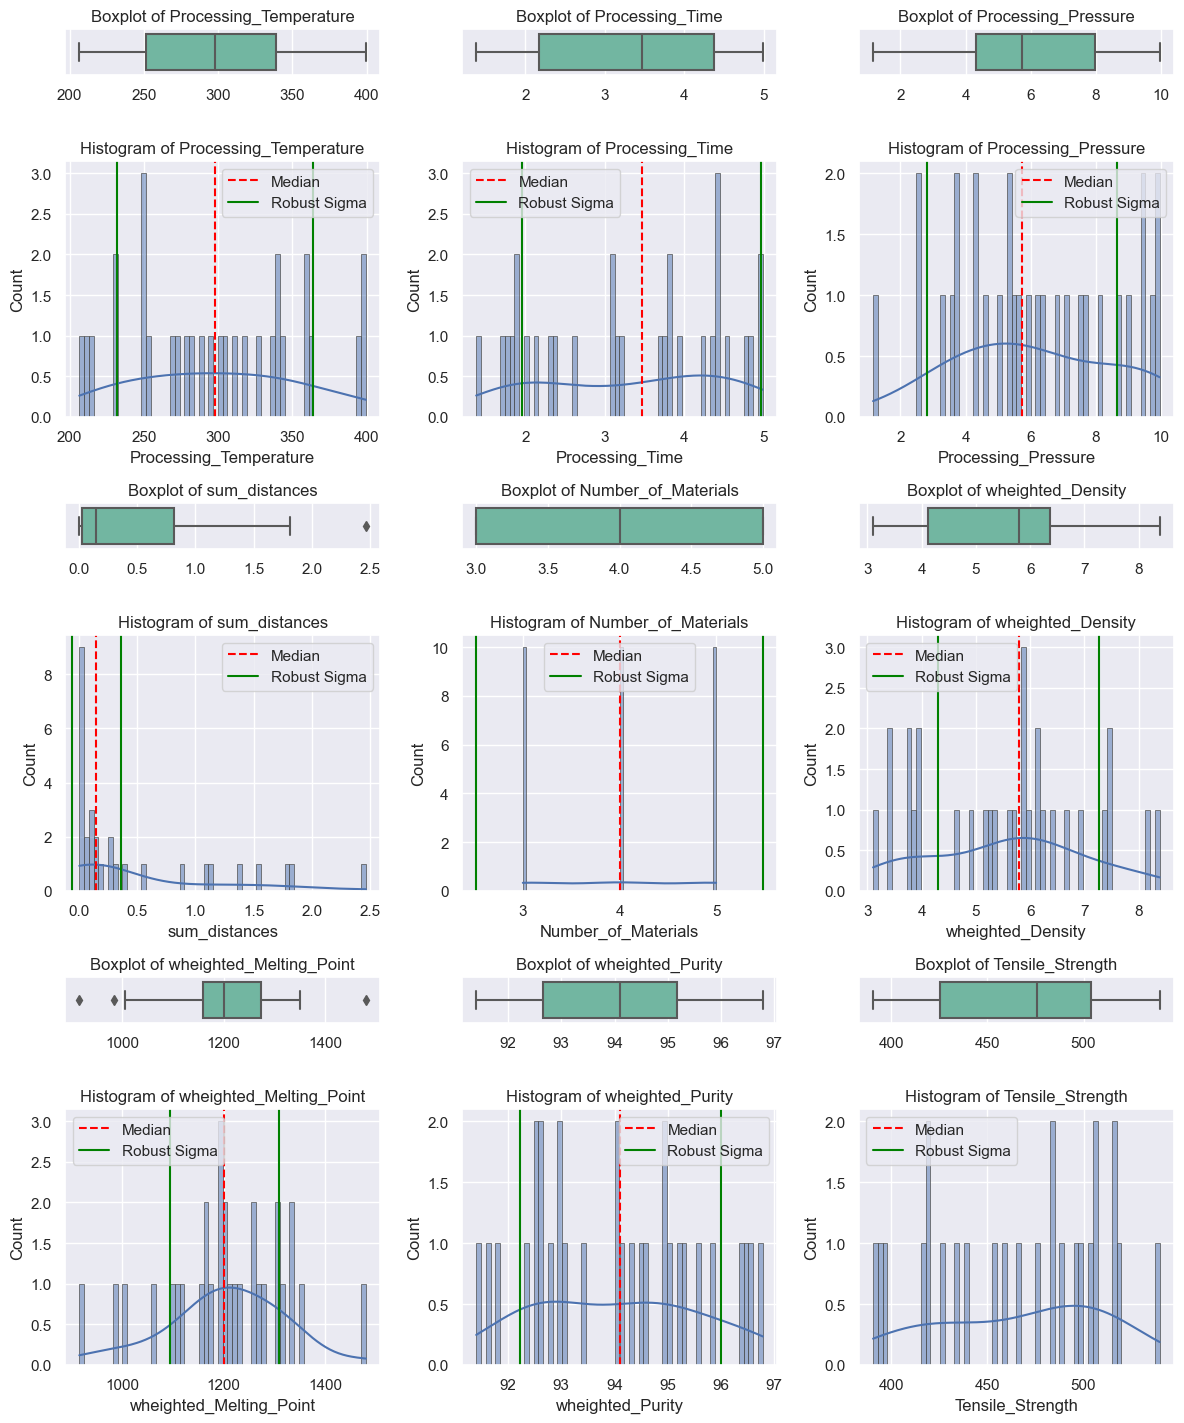

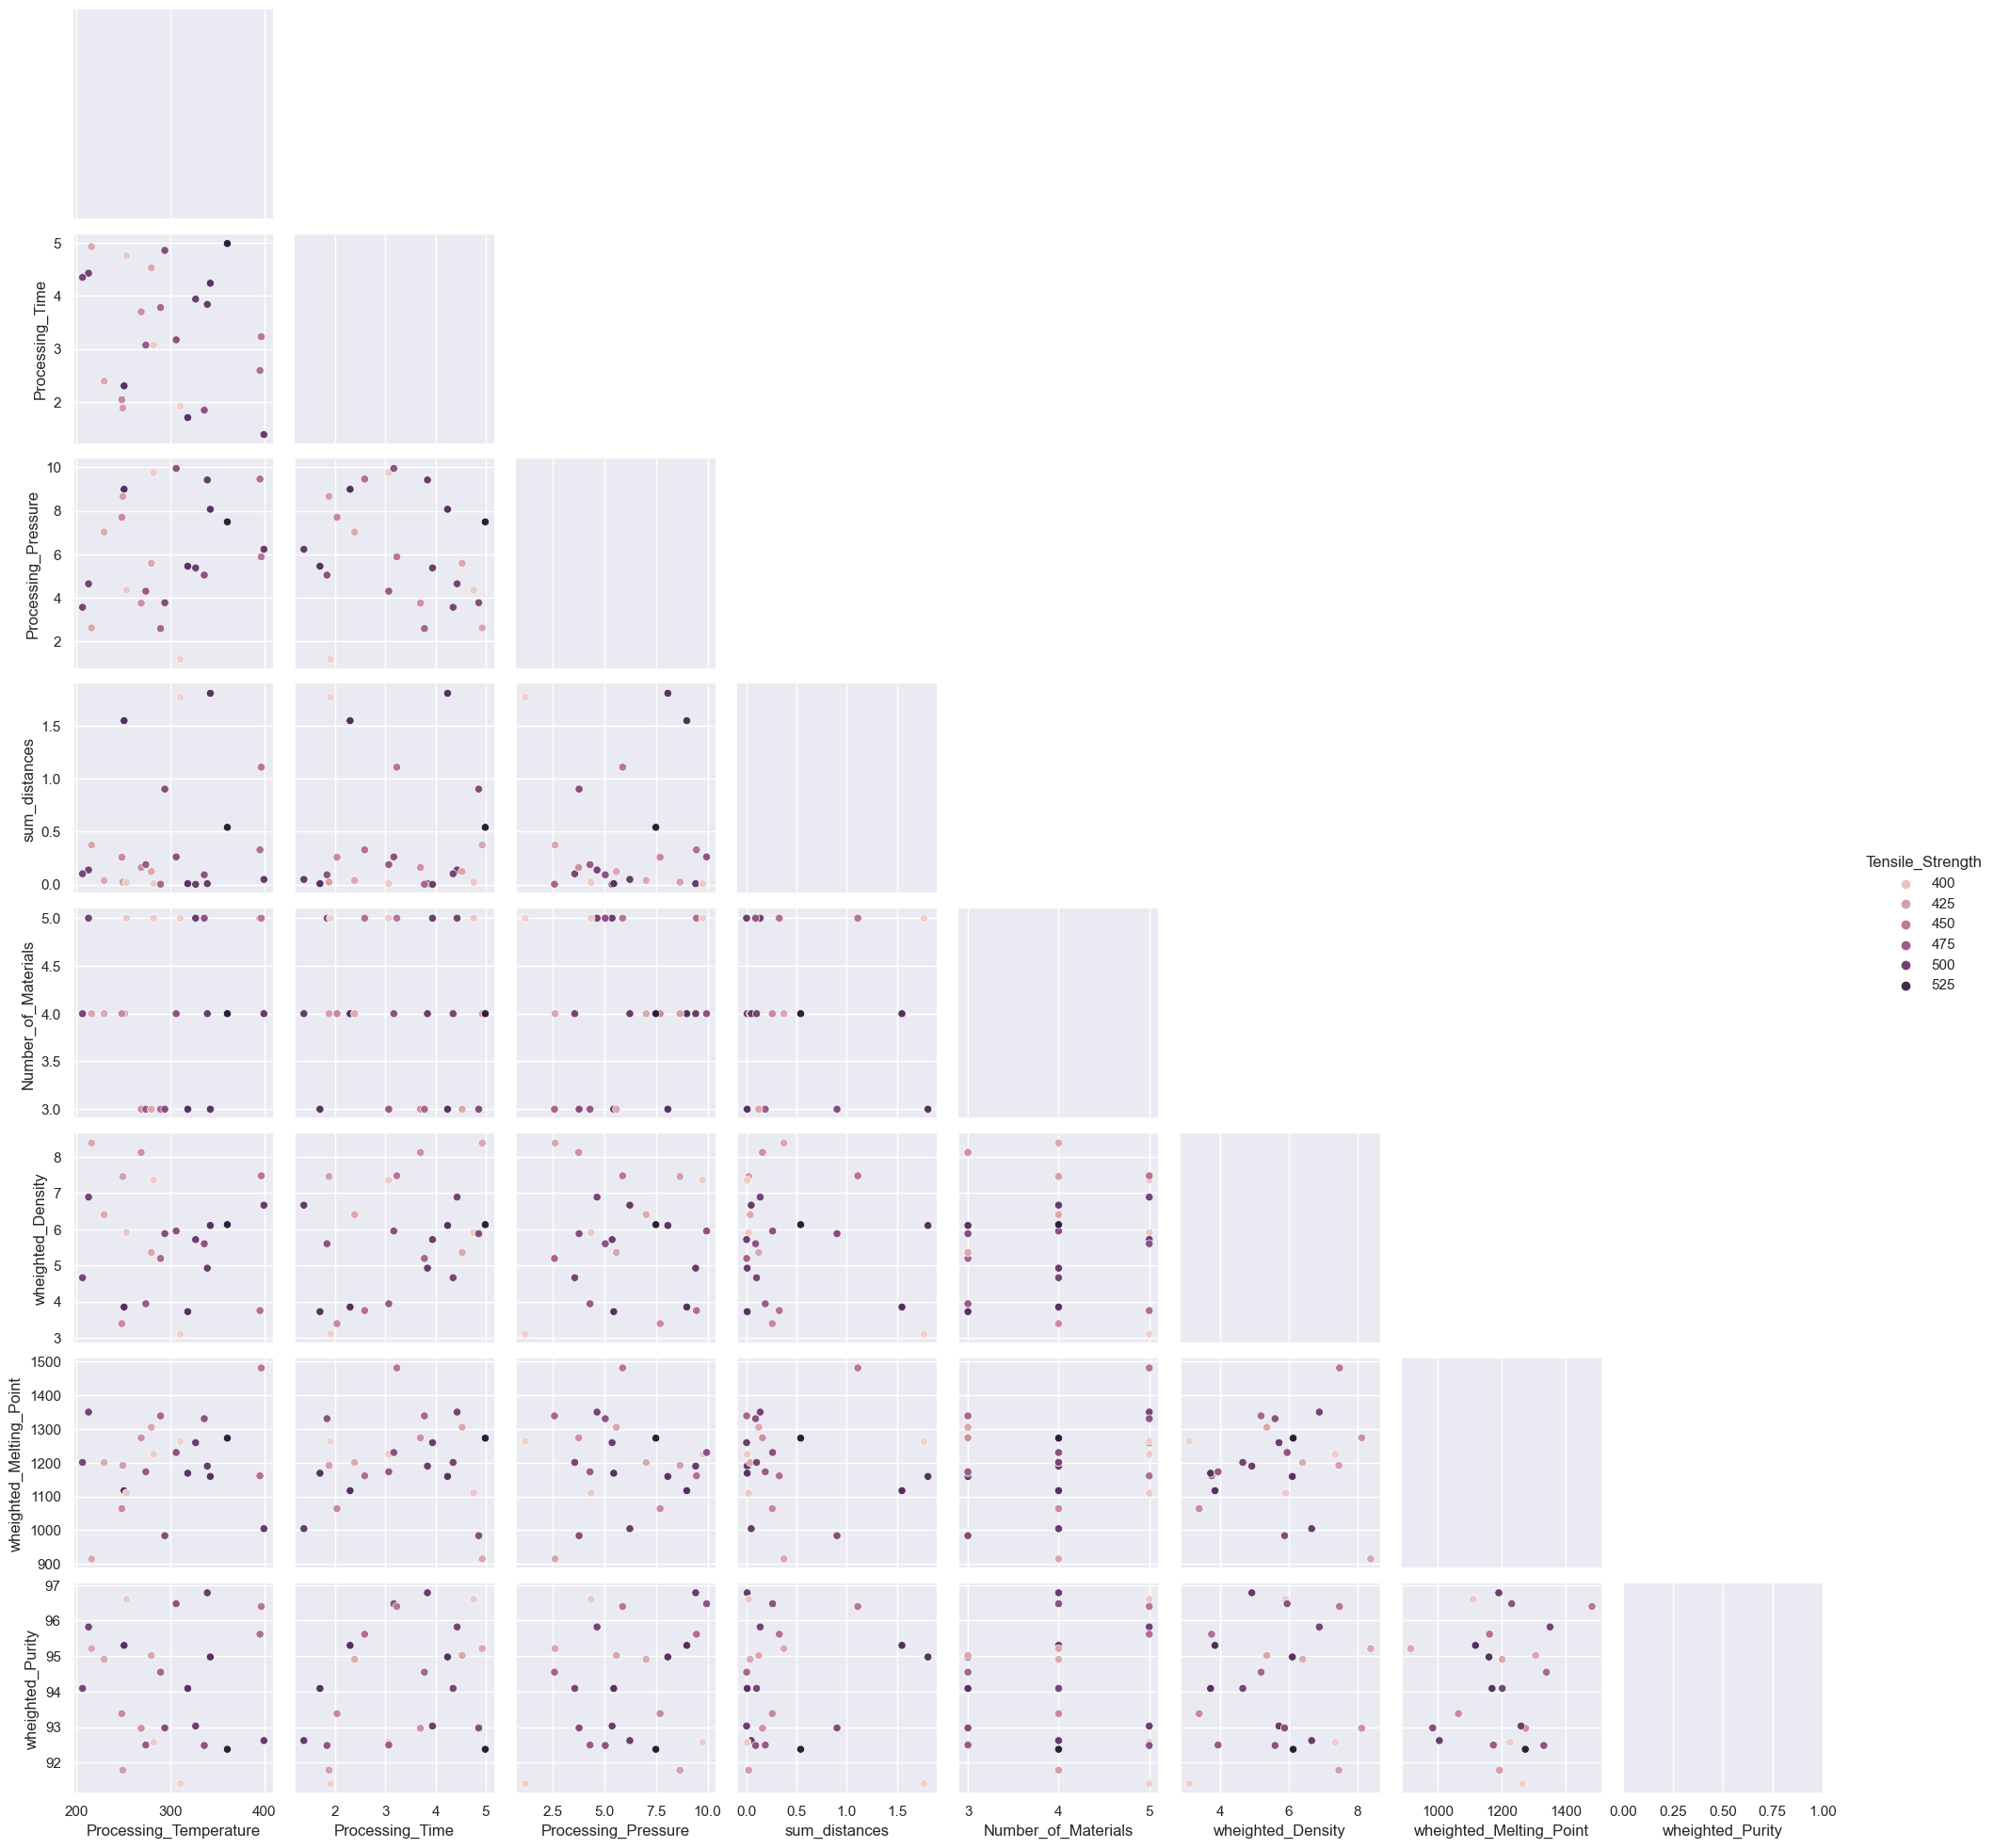

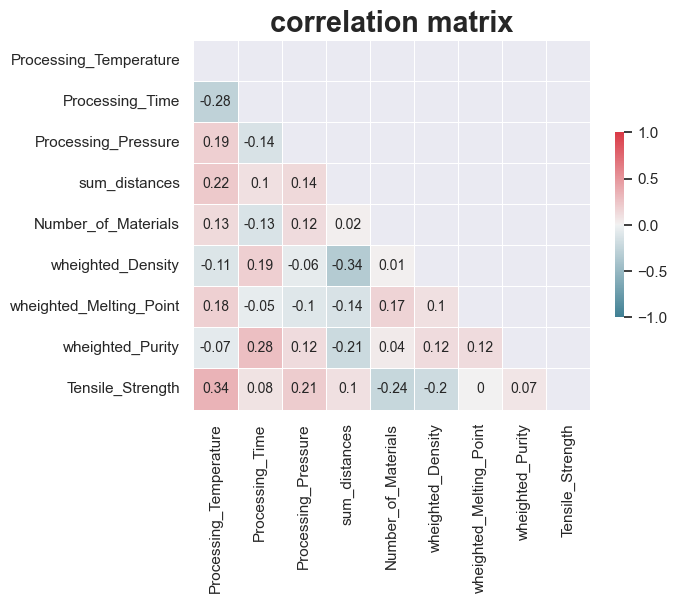

In [13]:
experiment_df_with_target = experiment_df.copy()
experiment_df_with_target["Tensile_Strength"] = Target
vis_raw_materials_df = Visualization(df = experiment_df_with_target)
vis_raw_materials_df.plot_histograms(bins = 60,rows= 6,cols = 3)

vis_raw_materials_df.pairplot_histograms(plot_features = experiment_df_with_target.columns,hue_column="Tensile_Strength")

vis_raw_materials_df.plot_correlation_matrix()

In [14]:
modeling_df = experiment_df.copy()
modeling_df["Melting_Point_pured"] = 100*modeling_df["wheighted_Melting_Point"]/modeling_df["wheighted_Purity"]
modeling_df["Melting_Point_pressure_Time"] = modeling_df["Melting_Point_pured"]/(modeling_df["Processing_Pressure"]*(modeling_df["Processing_Time"]))
modeling_df["Melting_Point_Temp_Time"] = modeling_df["Melting_Point_pured"]/(modeling_df["Processing_Temperature"]*(modeling_df["Processing_Time"]))

modeling_df["Density_Temp_Time"] = modeling_df["wheighted_Density"]/(modeling_df["Processing_Temperature"])
modeling_df["avg_distances"] = modeling_df["sum_distances"]/modeling_df["Number_of_Materials"]

modeling_df.drop(["wheighted_Melting_Point",'wheighted_Purity',"Processing_Time","Processing_Temperature","wheighted_Density","avg_distances",
                                     'Melting_Point_pured', 'Processing_Pressure',"sum_distances","Number_of_Materials"], axis=1, inplace=True)
modeling_df.describe()

,Melting_Point_pressure_Time,Melting_Point_Temp_Time,Density_Temp_Time
count,30.000000,30.000000,30.000000
mean,96.461915,1.502767,0.019382
std,107.546174,0.578386,0.007138
min,27.905676,0.740243,0.009496
25%,53.531125,0.977294,0.014570
50%,70.540868,1.398448,0.017659
75%,98.087551,2.015936,0.023129
max,623.874094,2.769886,0.038790


### Creating a new DataFrame for the normalized features

In [15]:
scaler = StandardScaler()
# Fitting the scaler to the features
features_normalized = scaler.fit_transform(modeling_df)

normalized_df = pd.DataFrame(features_normalized, columns=modeling_df.columns, index=modeling_df.index)

# Adding the non-normalized 'Tensile_Strength' column back into the DataFrame
modeling_df['Tensile_Strength'] = Target
normalized_df['Tensile_Strength'] = Target

normalized_df.describe()

,Melting_Point_pressure_Time,Melting_Point_Temp_Time,Density_Temp_Time,Tensile_Strength
count,3.000000e+01,3.000000e+01,3.000000e+01,25.000000
mean,-8.141636e-17,-5.773160e-16,8.067621e-16,465.809200
std,1.017095e+00,1.017095e+00,1.017095e+00,44.129447
min,-6.483562e-01,-1.340902e+00,-1.408704e+00,390.670000
25%,-4.060089e-01,-9.240472e-01,-6.856874e-01,425.430000
50%,-2.451428e-01,-1.834459e-01,-2.455149e-01,476.080000
75%,1.537411e-02,9.024096e-01,5.338695e-01,503.710000
max,4.987889e+00,2.228235e+00,2.765233e+00,539.570000


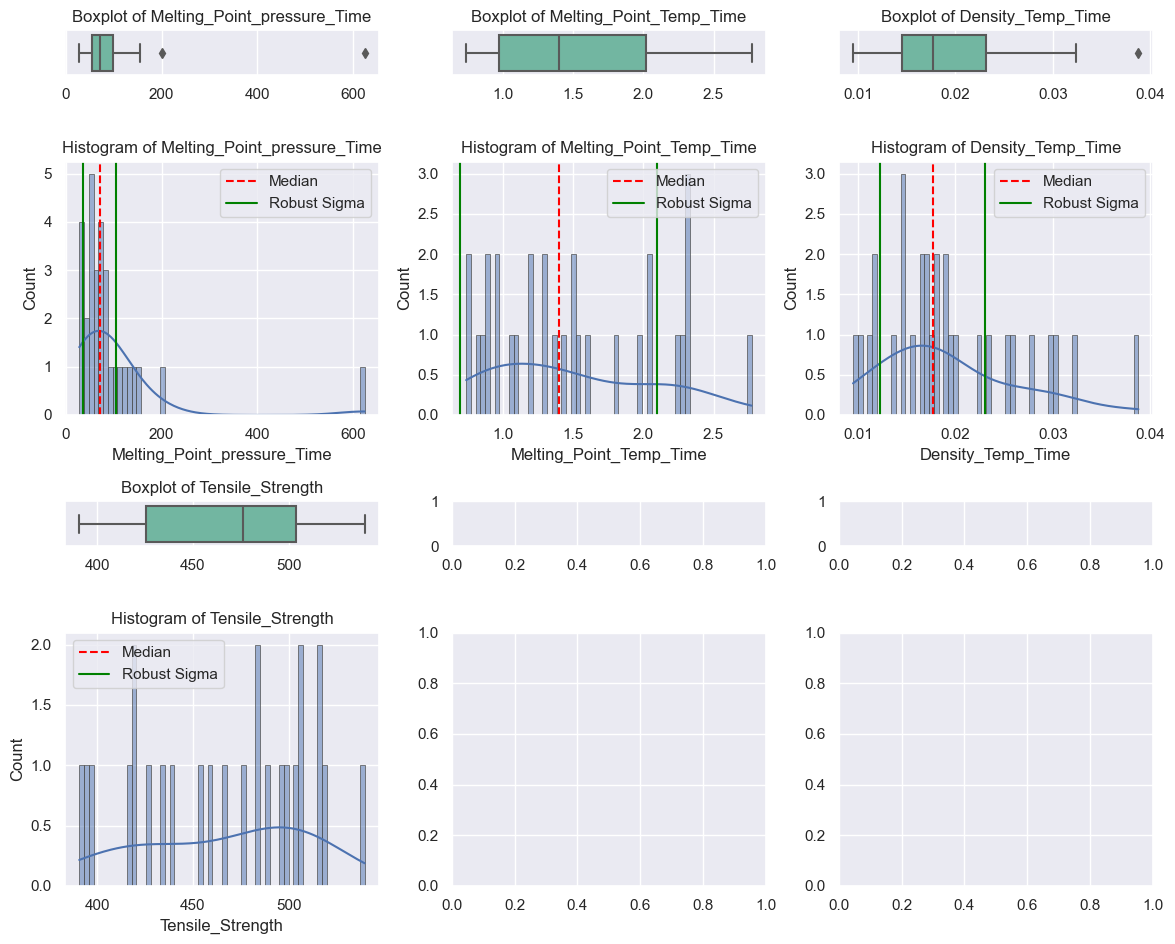

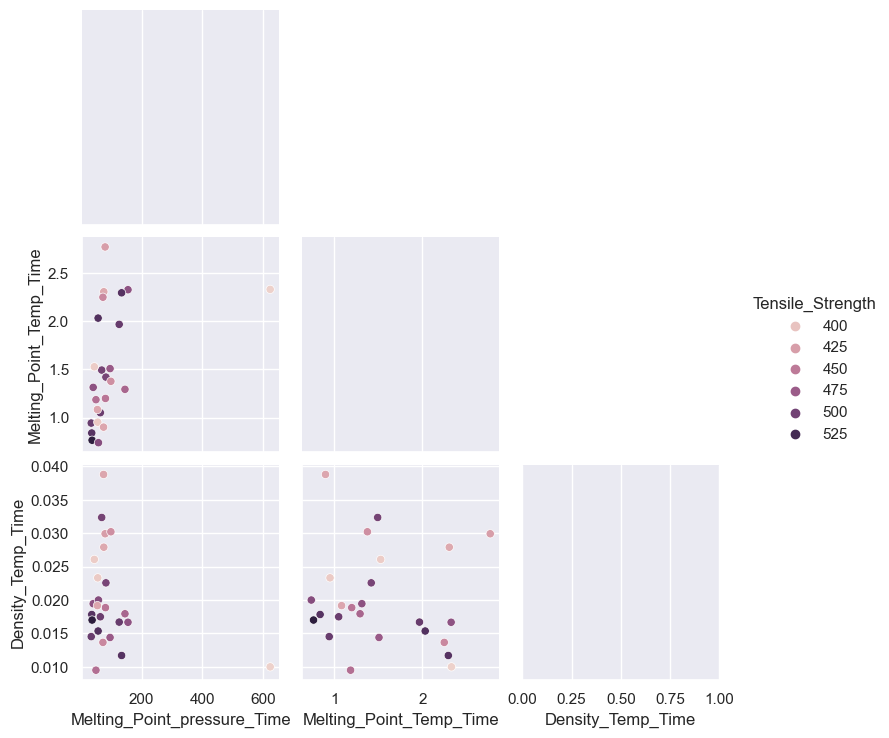

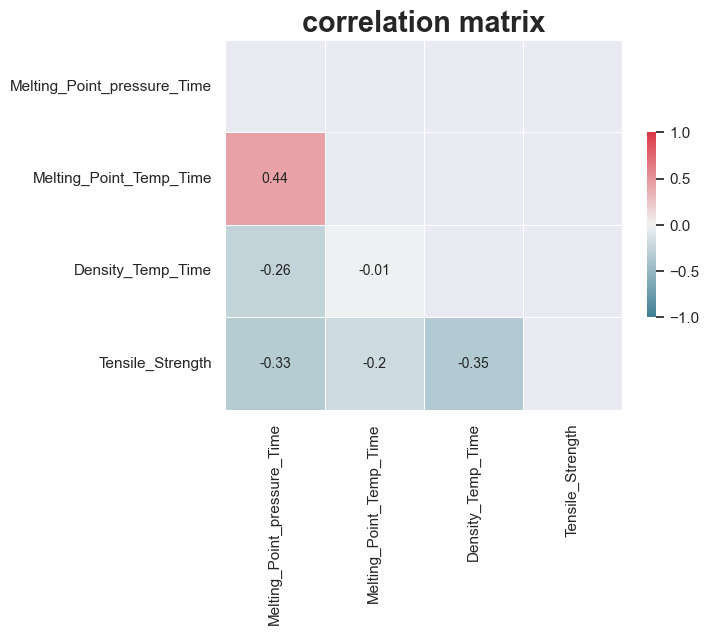

In [16]:
vis_raw_materials_df = Visualization(df = modeling_df)
vis_raw_materials_df.plot_histograms(bins = 60,rows= 4,cols = 3)

vis_raw_materials_df.pairplot_histograms(plot_features = modeling_df.columns,hue_column="Tensile_Strength")

vis_raw_materials_df.plot_correlation_matrix()

## Insights on Tensile Strength and Recommendations for Experiments

### Overview
Tensile strength has been extensively documented and experimented on for over 200 years. Many raw materials have well-known "pure" tensile strength values, which can be incorporated as features in our modeling process. Ductile materials like steel exhibit well-defined elastic behavior characterized by a linear stress-strain relationship.

### Key Recommendations
1. **Incorporate Pure Tensile Strength Data**:
   - Utilize existing literature to incorporate the pure tensile strength values of raw materials as additional features in the model. This will help in understanding the baseline behavior of each material.

2. **Scrap Redundant Data**:
   - Eliminate redundant data on raw materials with well-established properties to streamline the dataset and focus on more variable factors.

3. **Feature Engineering**:
   - **Melting Point and Purity**:
     - Pure substances have a higher and more precise melting point compared to impure substances or mixtures. Feature engineering based on the relationship between melting point and purity can provide valuable insights.
   - **Label Encoding**:
     - Consider label encoding the real data of raw materials and sensor types used for strain and stress measurements to capture more nuanced relationships.

### Experimentation Recommendations
Based on the model’s findings, the following specific experiments are recommended for the R&D team to optimize tensile strength using the existing raw materials:

1. **Adjust Raw Material Compositions**:
   - Experiment with varying the compositions of existing raw materials to understand their impact on tensile strength. This includes testing different alloys or composite materials.

2. **Processing Temperature**:
   - Conduct experiments at different processing temperatures to determine the optimal temperature that maximizes tensile strength for each raw material.

3. **Processing Time**:
   - Investigate the effects of different processing times on tensile strength. Shorter or longer processing times may influence the material's microstructure and, consequently, its tensile properties.

4. **Processing Pressure**:
   - Test the impact of varying pressures during processing. Higher or lower pressures could affect the density and internal structure of the material, influencing its tensile strength.

### Insights from Initial Models
- **Cosine Distance**:
  - Although the idea of using cosine distance was explored, the results were not significant. However, it remains a potential feature if combined with label encoding of raw material or sensor type data.

### Conclusion
These insights and recommendations are aimed at helping the R&D team design targeted experiments to optimize tensile strength. By incorporating pure tensile strength data, refining feature engineering techniques, and systematically varying processing parameters, we can achieve a deeper understanding and enhancement of the materials’ tensile properties.


## Modeling

In [17]:
class ModelComparison:
    def __init__(self, X_train, y_train, X_test, y_test,random_state):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.best_model = None
        self.models = {
            'Linear Regression': LinearRegression(),
            'Lasso Regression': Lasso(alpha=0.01),
            'Ridge Regression': Ridge(alpha=0.05),
            'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.7),
            'Random Forest Regressor': RandomForestRegressor(random_state=random_state),
            'SVR': SVR(),
            'XGBoost Regressor': xgb.XGBRegressor(objective='reg:squarederror', random_state=random_state),
            'CatBoost Regressor': CatBoostRegressor(verbose=0, random_state=random_state),
            'Bayesian Ridge Regression': BayesianRidge()  # Adding Bayesian Ridge Regression

        }
        self.results = pd.DataFrame()
        self.predictions = {}  # To store model predictions for later use in plotting

    def train(self,fit_best = False,X = None,y = None):

        if fit_best:
            self.fittest_model = self.models[self.best_model]
            self.fittest_model.fit(X, y)
            print(f"Best model {self.best_model} trained successfully.")            
        else:
            # Train each model on the training set
            for name, model in self.models.items():
                model.fit(self.X_train, self.y_train)
                print(f"Model {name} retrained successfully.")

    def calculate_regression_metrics(self, name, actual, y_pred):
        mae = mean_absolute_error(actual, y_pred)
        mse = mean_squared_error(actual, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((actual - y_pred) / actual)) * 100
        r2 = r2_score(actual, y_pred)

        metrics_df = pd.DataFrame({
            '#': ['MAE', 'MSE', 'RMSE', 'MAPE', 'R^2'],
            name: [mae, mse, rmse, mape, r2]
        })

        metrics_df_indexed = metrics_df.set_index('#').T
        return metrics_df_indexed

    def evaluate(self):
        # Evaluate each model on the test set
        for name, model in self.models.items():
            y_pred = model.predict(self.X_test)
            self.predictions[name] = y_pred  # Store predictions
            # Calculate metrics and concatenate to the results DataFrame
            metrics_df = self.calculate_regression_metrics(name, self.y_test, y_pred)
            self.results = pd.concat([self.results, metrics_df], ignore_index=True)
        
        # Add model names to the results DataFrame and sort by MAPE
        self.results["Model"] = self.models.keys()
        self.results = self.results.sort_values(by=('MAPE'), ascending=True)
        self.best_model = self.results["Model"].iloc[0]
        return self.results

    def plot_evaluation(self,model_name, best_model = False):

        if model_name in self.models and model_name in self.predictions:
            model = self.models[model_name]
            y_pred = self.predictions[model_name]
            if best_model:
                y_pred = self.fittest_model.predict(self.X_test)
            residuals = y_pred - self.y_test
            fig, axs = plt.subplots(2, 2, figsize=(15, 10))

            sns.scatterplot(x=y_pred, y=self.y_test, ax=axs[0, 0], label='Data Points')
            axs[0, 0].plot(y_pred, y_pred, color='red', label=f'Line: $R^2$ = {r2_score(self.y_test, y_pred):.2f}')
            axs[0, 0].set_xlabel('Actual Values')
            axs[0, 0].set_ylabel('Predicted Values')
            axs[0, 0].set_title(f'{model_name} - Scatter Plot of Predicted vs. Actual Values')
            axs[0, 0].legend()

            if hasattr(model, 'feature_importances_'):
                feature_importances = model.feature_importances_
                sorted_indices = np.argsort(feature_importances)[::-1]
                sorted_feature_names = np.array(self.X_test.columns)[sorted_indices]
                feature_importance_df = pd.DataFrame({'Feature': sorted_feature_names, 'Importance': feature_importances[sorted_indices]})
                axs[0, 1].barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
                axs[0, 1].set_xlabel('Importance')
                axs[0, 1].set_ylabel('Feature')
                axs[0, 1].set_title(f'{model_name} - Feature Importance')
                axs[0, 1].invert_yaxis()

            sm.qqplot(residuals, line='s', ax=axs[1, 0])
            axs[1, 0].set_title(f'{model_name} - Q-Q Plot')

            n = len(y_pred)
            k = 1  # Number of predictors
            threshold = 4 / (n - k - 1)
            model_influence = OLSInfluence(sm.OLS(y_pred, sm.add_constant(self.X_test)).fit())
            cooks = model_influence.cooks_distance[0]

            axs[1, 1].vlines(x=np.arange(len(cooks)), ymin=0, ymax=cooks, color='tab:blue')
            axs[1, 1].axhline(y=threshold, color='red', linestyle='--', label=f'Threshold: 4/(n-k-1) = {threshold:.2f}')
            axs[1, 1].set_xlabel('Observation Index')
            axs[1, 1].set_ylabel("Cook's Distance")
            axs[1, 1].set_title("Cook's Distance Plot")
            axs[1, 1].legend()

            plt.tight_layout()
            plt.show()
        else:
            print(f"Model {model_name} not found or no predictions available.")

    def predict_new_samples(self, new_X):
        # Select the best model based on the lowest MAPE value
        best_model_name = self.results.iloc[0]['Model']  # Assuming the results are sorted by MAPE, ascending
        best_model = self.models[best_model_name]
        
        # Predict using the best model
        new_predictions = best_model.predict(new_X)
        
        return new_predictions


In [18]:
test_rows = 5
random_state = 902010

Train_df = normalized_df.iloc[:-test_rows]
Test_df = normalized_df.iloc[-test_rows:]
X = Train_df.drop('Tensile_Strength', axis=1)  # excluding test rows and target variable
y = Train_df['Tensile_Strength']

# Split data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_state)

# Creating a ModelComparison instance
comparison_instance = ModelComparison(X_train, y_train, X_val, y_val,random_state)

# Training the models and evaluating them
comparison_instance.train()
comparison_instance.evaluate()

Model Linear Regression retrained successfully.
Model Lasso Regression retrained successfully.
Model Ridge Regression retrained successfully.
Model ElasticNet retrained successfully.
Model Random Forest Regressor retrained successfully.
Model SVR retrained successfully.
Model XGBoost Regressor retrained successfully.
Model CatBoost Regressor retrained successfully.
Model Bayesian Ridge Regression retrained successfully.


#,MAE,MSE,RMSE,MAPE,R^2,Model
7,15.169454,633.385154,25.167144,3.041672,0.427068,CatBoost Regressor
4,17.462700,677.587500,26.030511,3.511689,0.387084,Random Forest Regressor
0,18.689687,780.371931,27.935138,3.886364,0.294110,Linear Regression
1,18.697429,779.758134,27.924150,3.888062,0.294665,Lasso Regression
2,18.716280,778.359605,27.899097,3.891677,0.295930,Ridge Regression
3,18.726832,777.549192,27.884569,3.893887,0.296663,ElasticNet
8,22.605007,717.183753,26.780287,4.681163,0.351267,Bayesian Ridge Regression
5,29.884366,1090.092146,33.016544,6.390464,0.013950,SVR
6,34.635198,2120.171812,46.045323,7.048325,-0.917815,XGBoost Regressor


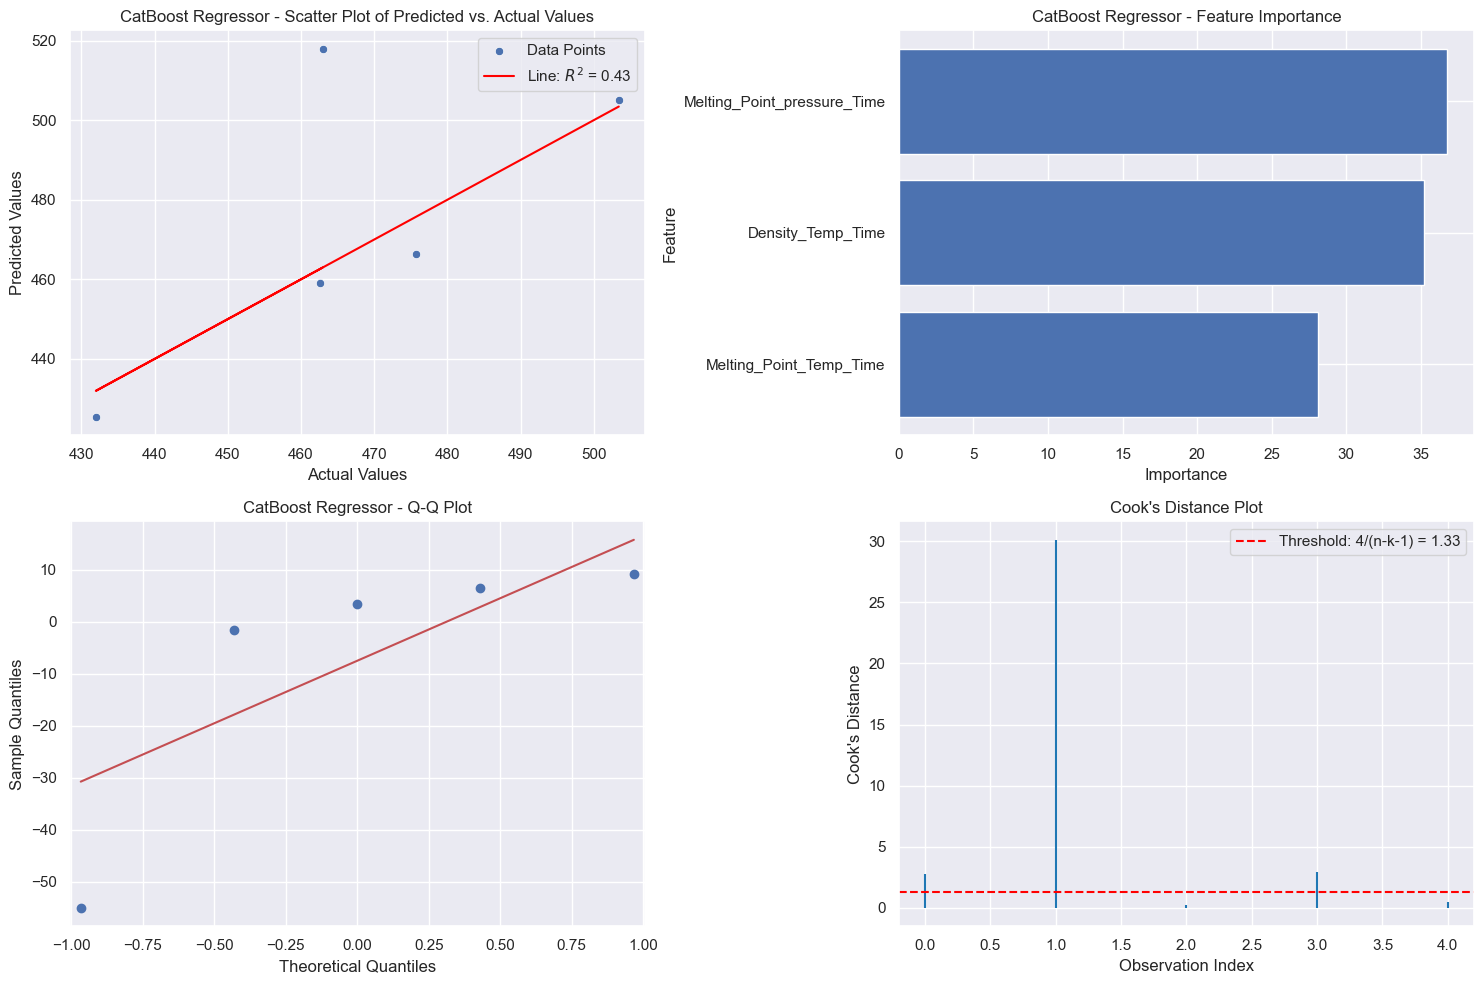

In [19]:
comparison_instance.plot_evaluation(comparison_instance.best_model)

## Recommendations:

### Model Selection:
* The CatBoost Regressor is recommended as the best-performing model for predicting tensile strength due to its superior accuracy and higher R^2 value.

### Hyperparameter Tuning:
* While the CatBoost Regressor performed well, further hyperparameter tuning could potentially improve its performance even more.

### Feature Engineering:
* The moderate R^2 values across most models suggest that additional feature engineering or the inclusion of new relevant features could enhance the model's performance.

### Model Validation:
* Given the limited data, consider using cross-validation to ensure the robustness of the model's performance.

### Additional Data:
* Collecting more data points could improve the model's generalizability and provide more reliable performance estimates.

### Model Interpretability:
* Investigate the feature importances and partial dependence plots from the CatBoost model to gain insights into how different features impact tensile strength predictions.

## Hyperparameter tuning

In [24]:
class HyperparameterTuner:
    def __init__(self, metric: Callable = mean_absolute_error, early_stopping_rounds: int = 100, random_state: int = 902010):
        self.metric = metric
        self.early_stopping_rounds = early_stopping_rounds
        self.random_state = random_state

    def hyperparameter_tuning(self, space: Dict[str, Union[float, int]], 
                              X_train: pd.DataFrame, y_train: pd.Series, 
                              X_val: pd.DataFrame, y_val: pd.Series) -> Dict[str, Any]:
        
        model = CatBoostRegressor(**space, random_seed=self.random_state, 
                                  early_stopping_rounds=self.early_stopping_rounds, verbose=False)
        model.fit(X_train, y_train, eval_set=(X_val, y_val))

        pred = model.predict(X_val)
        score = self.metric(y_val, pred)
        return {'loss': score, 'status': STATUS_OK, 'model': model}

    def tune_and_train(self, space, X_train, y_train, X_val, y_val):
        trials = Trials()
        best = fmin(fn=lambda space: self.hyperparameter_tuning(space, X_train, y_train,
                                                                X_val, y_val),            
                    space=space,           
                    algo=tpe.suggest,            
                    max_evals=50,            
                    trials=trials)

        best_model = CatBoostRegressor(**best, random_seed=self.random_state)
        best_model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=100)
        return best_model, trials

# Define the complete search space here
space = {
    'depth': hp.choice('depth', range(1, 11)),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    # 'random_strength': hp.uniform('random_strength', 1, 20),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1)
}

# Assuming your data is already prepared
tuner = HyperparameterTuner(random_state = random_state)
best_model, all_trials = tuner.tune_and_train(space, X_train, y_train, X_val, y_val)

comparison_instance.calculate_regression_metrics(comparison_instance.best_model + " - Hypertuned",
                                                  actual = y_val,y_pred = best_model.predict(X_val))

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [00:18<00:00,  2.65trial/s, best loss: 13.208486398352544]
0:	learn: 44.7945966	test: 34.5134164	best: 34.5134164 (0)	total: 324us	remaining: 324ms
100:	learn: 27.9732509	test: 22.7812837	best: 22.1675425 (91)	total: 28.6ms	remaining: 255ms
200:	learn: 18.7518803	test: 24.8797891	best: 22.1675425 (91)	total: 63ms	remaining: 250ms
300:	learn: 13.1031409	test: 26.6211073	best: 22.1675425 (91)	total: 93.7ms	remaining: 218ms
400:	learn: 9.3271215	test: 27.8226283	best: 22.1675425 (91)	total: 129ms	remaining: 193ms
500:	learn: 6.8784745	test: 28.8030922	best: 22.1675425 (91)	total: 158ms	remaining: 158ms
600:	learn: 5.1254311	test: 30.3784649	best: 22.1675425 (91)	total: 200ms	remaining: 133ms
700:	learn: 3.8627198	test: 31.4040851	best: 22.1675425 (91)	total: 232ms	remaining: 98.9ms
800:	learn: 2.8648560	test: 32.0818781	best: 22.1675425 (91)	total: 260ms	remaining: 64.7ms
900:	learn: 2.1173506	test: 32.4215799	best: 22.1675425 (91)	total: 292ms	remaining: 32.1ms
999

#,MAE,MSE,RMSE,MAPE,R^2
CatBoost Regressor - Hypertuned,18.245115,491.400013,22.167544,3.746112,0.555501


## Results

In [25]:
comparison_instance.fittest_model = best_model
comparison_instance.train(fit_best = True,X = pd.concat([X_train,X_val]), y = pd.concat([y_train,y_val]))

X_Test = Test_df.drop('Tensile_Strength', axis=1)
Test_results = comparison_instance.fittest_model.predict(X_Test)

num_rows = len(formulations_df_final)
formulations_df_final.loc[num_rows-5:num_rows, 'Tensile_Strength'] = Test_results

formulations_df_final

Best model CatBoost Regressor trained successfully.


,Formulation_ID,Formulation_Name,Processing_Temperature,Processing_Time,Processing_Pressure,RM1,RM2,RM3,RM4,RM5,...,RM24,RM25,RM26,RM27,RM28,RM29,RM30,Number_of_Materials,Percentage_Sum,Tensile_Strength
0,F1,Formulation_01,213.0,4.43,4.64,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,7.0,0.0,5,100.0,498.050000
1,F2,Formulation_02,250.8,2.30,8.99,0.0,0.0,0.0,0.0,0.0,...,12.0,0.0,0.0,0.0,4.0,0.0,0.0,4,100.0,517.930000
2,F3,Formulation_03,249.4,1.88,8.66,0.0,0.0,24.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4,100.0,425.430000
3,F4,Formulation_04,339.3,3.84,9.42,0.0,0.0,27.0,8.0,0.0,...,0.0,0.0,0.0,0.0,11.0,0.0,0.0,4,100.0,505.060000
4,F5,Formulation_05,342.5,4.24,8.07,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,100.0,515.620000
5,F6,Formulation_06,229.6,2.39,7.02,0.0,0.0,0.0,27.0,0.0,...,0.0,0.0,16.0,0.0,0.0,0.0,0.0,4,100.0,416.850000
6,F7,Formulation_07,399.5,1.38,6.23,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,100.0,506.260000
7,F8,Formulation_08,253.4,4.76,4.35,0.0,9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,100.0,395.900000
8,F9,Formulation_09,395.3,2.59,9.46,0.0,0.0,0.0,0.0,0.0,...,0.0,15.0,0.0,28.0,0.0,0.0,0.0,5,100.0,459.150000
9,F10,Formulation_10,282.2,3.07,9.76,0.0,3.0,0.0,0.0,0.0,...,6.0,0.0,1.0,0.0,0.0,0.0,0.0,5,100.0,394.190000


## Appendix: Design Of Experiment (DOE)

With only 25 samples, traditional machine learning might struggle to generalize well. 

Design of Experiments (DOE) can be very useful in such cases as it focuses on systematically planning experiments to understand the factors affecting your outcomes. 

There are software tools like JMP for DOE, offering features like factorial designs, response surface methodologies, and more. 

However, in this section, I will use `statsmodels` and `pyDOE2` in Python to perform DOE, as they provide robust functionalities for exploring the relationships between variables efficiently, especially with small datasets.

In [22]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pyDOE2 import lhs

                            OLS Regression Results                            
Dep. Variable:       Tensile_Strength   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     3.331
Date:                Sun, 19 May 2024   Prob (F-statistic):             0.0392
Time:                        21:42:02   Log-Likelihood:                -124.78
No. Observations:                  25   AIC:                             257.6
Df Residuals:                      21   BIC:                             262.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

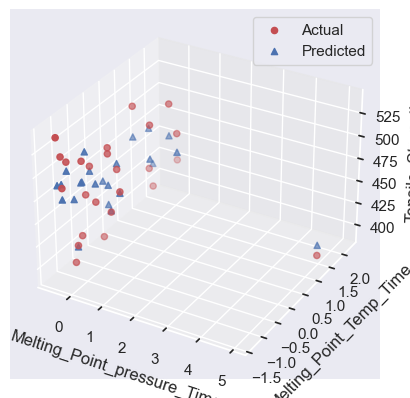

Mean Absolute Error: 28.72
                Melting_Point_pressure_Time  Melting_Point_Temp_Time  \
Formulation_ID                                                         
F26                                0.171766                 1.233060   
F27                                1.112987                 0.628941   
F28                               -0.564432                 0.230688   
F29                                0.228313                 0.368507   
F30                                0.151898                 0.430195   

                Density_Temp_Time  PredictedStrength  
Formulation_ID                                        
F26                     -0.404825         469.888960  
F27                     -0.741928         461.583185  
F28                      1.333744         450.257286  
F29                      0.403180         454.717131  
F30                      0.417907         455.615397  


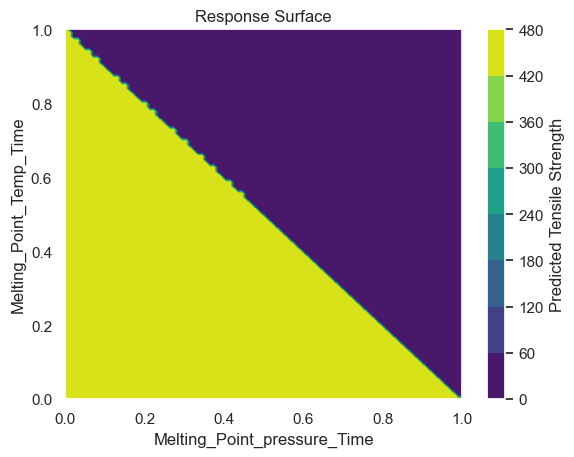

In [23]:
# Generate mixture design using Latin Hypercube Sampling
def generate_mixture_design(n_samples, n_factors):
    # Generate samples from a Latin Hypercube Sampling
    samples = lhs(n_factors, samples=n_samples, criterion='center')
    # Normalize the samples to make sure they sum to 1 (for mixture design)
    samples /= samples.sum(axis=1, keepdims=True)
    return samples

df_mixture = Train_df.copy()

# Fit the mixture model using ordinary least squares (OLS)
model = ols('Tensile_Strength ~ Melting_Point_pressure_Time + Melting_Point_Temp_Time + Density_Temp_Time', data=df_mixture).fit()

# Summary of the model
print(model.summary())

# Predicting and plotting the response surface
df_mixture['PredictedStrength'] = model.predict(df_mixture)

# Visualizing the response surface
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_mixture['Melting_Point_pressure_Time'], df_mixture['Melting_Point_Temp_Time'], df_mixture['Tensile_Strength'], c='r', marker='o', label='Actual')
ax.scatter(df_mixture['Melting_Point_pressure_Time'], df_mixture['Melting_Point_Temp_Time'], df_mixture['PredictedStrength'], c='b', marker='^', label='Predicted')
ax.set_xlabel('Melting_Point_pressure_Time')
ax.set_ylabel('Melting_Point_Temp_Time')
ax.set_zlabel('Tensile_Strength')
plt.legend()
plt.show()

mae = np.mean(np.abs(df_mixture['Tensile_Strength'] - df_mixture['PredictedStrength']))
print(f'Mean Absolute Error: {mae:.2f}')

# Predict on new data
new_data = X_Test.copy()

# Ensure the proportions sum to 1
new_data = new_data.apply(lambda row: row / row.sum(), axis=1)

# Predict tensile strength for the new formulations
new_data['PredictedStrength'] = model.predict(new_data)
print(new_data)

# Optional: plotting the response surface over a grid (useful for 2D visualizations)
def plot_response_surface_2d(model, factor1, factor2, n_points=100):
    factor1_range = np.linspace(0, 1, n_points)
    factor2_range = np.linspace(0, 1, n_points)
    factor1_mesh, factor2_mesh = np.meshgrid(factor1_range, factor2_range)
    
    response_values = np.zeros_like(factor1_mesh)
    
    for i in range(factor1_mesh.shape[0]):
        for j in range(factor1_mesh.shape[1]):
            # Proportions must sum to 1, so the third factor is 1 - sum of the first two
            factor3_value = 1 - factor1_mesh[i, j] - factor2_mesh[i, j]
            if factor3_value >= 0:
                response_values[i, j] = model.predict(pd.DataFrame({
                    factor1: [factor1_mesh[i, j]],
                    factor2: [factor2_mesh[i, j]],
                    'Density_Temp_Time': [factor3_value]
                }))[0]
    
    plt.contourf(factor1_mesh, factor2_mesh, response_values, cmap='viridis')
    plt.colorbar(label='Predicted Tensile Strength')
    plt.xlabel(factor1)
    plt.ylabel(factor2)
    plt.title('Response Surface')
    plt.show()

# Plot response surface for the first two raw materials
plot_response_surface_2d(model, 'Melting_Point_pressure_Time', 'Melting_Point_Temp_Time')

## Conclusions and Recommendations for DOE

* The model shows that `Melting_Point_pressure_Time` and `Density_Temp_Time` are significant predictors of tensile strength, both having a negative impact. 

* `Melting_Point_Temp_Time` does not significantly affect tensile strength, and it might be considered for removal in future model iterations to simplify the model.

* The R-squared value indicates a modest fit, suggesting that there may be other important predictors not included in the model. Further feature engineering or the inclusion of additional variables may improve the model's performance.

* Given the limited number of observations (25), the model may benefit from additional data to provide more robust estimates and improve generalizability.

* Consider cross-validation or bootstrapping techniques to validate the stability of the model with the current dataset size.

* The CatBoost Regressor achieved better metrics (MAE: 18.245115, MSE: 491.400013, RMSE: 22.167544, MAPE: 3.746112, R^2: 0.555501). However, due to the low number of samples, we should be cautious about these results. Only with more data can we validate the model's performance and reliability.

In summary, while the model has identified significant predictors of tensile strength, its explanatory power is limited, and further refinement and additional data collection are recommended to improve the model's performance.


## Productization Proposal Design

### Overview
This proposal outlines a theoretical design for a product that guides researchers in optimizing tensile strength through user-friendly interfaces and real-time data analysis.

### Key Components

1. **Dashboard**
   - **Features**: Key metrics, recent experiments, material performance overview.
   - **UI Elements**: Summary tiles, recent activity feed, performance charts.

2. **Data Input Forms**
   - **Features**: Input for raw material properties, processing parameters, experimental results.
   - **UI Elements**: Dropdown menus, text fields, file upload options.

3. **Visualization Tools**
   - **Features**: Visual representation of data relationships.
   - **UI Elements**: Interactive graphs, charts, heatmaps.

4. **Recommendation Engine**
   - **Features**: Suggests new experiments based on data.
   - **UI Elements**: Suggestion box, actionable insights.

5. **Real-Time Analytics**
   - **Features**: Processes data in real-time, provides immediate feedback.
   - **UI Elements**: Live data feed, instant analysis results.

6. **Data Engineering Pipeline (Data as a Service - DaaS)**

   - **Features**: Ensures seamless data flow and transformation, integrates with various data sources and sinks.
   - **Components**: Data ingestion, data processing, data storage, and data delivery mechanisms.


### Data Flow Diagram

1. **API Integration**:
   - **Purpose**: Connects to external databases, research tools, and laboratory equipment.
   - **Function**: Ensures seamless data exchange and real-time updates.

2. **User Interface**:
   - **Purpose**:  Collects input data from researchers and displays analyzed results.
   - **Function**: Facilitates easy interaction and visualization.

3. **Data Input/Output**:
   - **Purpose**: Allows for easy input of experimental data, material properties, and processing parameters.
   - **Function**: Outputs visualizations and experiment recommendations.

4. **Data Engineering Pipeline (DaaS)**:

   - **Purpose**: Manages data ingestion, processing, storage, and delivery.
   - **Function**: Ensures efficient data flow and transformation, supports real-time interaction and analysis.

5. **Real-Time Interaction**:

   - **Purpose**: Processes and analyzes data in real-time.
   - **Function**: Provides immediate feedback and adjusts recommendations based on new data.

### Mockup (Wireframe Example)

```plaintext
+------------------------------------------------------------+
|                        Dashboard                           |
|------------------------------------------------------------|
|  Key Metrics  |  Recent Experiments  |  Material Overview  |
|------------------------------------------------------------|
|  Metric 1     |  Experiment 1        |  Performance Chart  |
|  Metric 2     |  Experiment 2        |                     |
|------------------------------------------------------------|
|                      Data Input Forms                      |
|------------------------------------------------------------|
|  Raw Material Properties                                   |
|  [Dropdown | Text Field | Upload]                          |
|------------------------------------------------------------|
|  Processing Parameters                                     |
|  [Dropdown | Text Field | Upload]                          |
|------------------------------------------------------------|
|                     Visualization Tools                    |
|------------------------------------------------------------|
|  [Interactive Graph | Chart | Heatmap]                     |
|------------------------------------------------------------|
|                     Recommendation Engine                  |
|------------------------------------------------------------|
|  Suggestions:                                              |
|  1. Adjust material composition                            |
|  2. Change processing temperature                          |
|------------------------------------------------------------|
|                      Real-Time Analytics                   |
|------------------------------------------------------------|
|  [Live Data Feed | Instant Analysis Results]               |
+------------------------------------------------------------+
|                  Data Engineering Pipeline (DaaS)          |
|------------------------------------------------------------|
|  Data Ingestion | Data Processing | Data Storage | Data Delivery |
+------------------------------------------------------------+


This theoretical design provides a comprehensive framework for productizing the tensile strength optimization capability. 

By integrating APIs, designing an intuitive UI, implementing a robust data engineering pipeline, and supporting real-time interaction, this product can significantly enhance the research and development process, guiding researchers, accelerating experimentation, and improving material development.